#Surgical Image Enhancement , De-smoking and segmentation ofsurgical tools

#Importing Libraries

In [1]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from scipy.spatial import distance
import smoky as ex

/home/sayak/Documents/personal/vit/study/thirdY6thSem/tarp/surgical_tool_seg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sayak/Documents/personal/vit/study/thirdY6thSem/tarp/surgical_tool_seg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sayak/Documents/personal/vit/study/thirdY6thSem/tarp/surgical_tool_seg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood a

#Image Enhancement using Constrast Ltd Adaptive Histogram Equalization (CLAHE)

In [2]:
#clipLimit – This parameter sets the threshold for contrast limiting. The default value is 40.
# tileGridSize – This sets the number of tiles in the row and column. By default this is 8×8. It is used while the image is divided into tiles for applying CLAHE.
def hisEqulColor(img):
  ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
  channels = cv2.split(ycrcb)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  channels[0] = clahe.apply(channels[0])
  cv2.merge(channels, ycrcb)
  cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
  return img

#Create classes for Image Segmentation

In [3]:
#testing- for debugging: whether masks loaded properly
def get_ax(rows=1, cols=1, size=8):
  _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
  return ax

#class to control h/w- for segmentation
class MicrocontrollerConfig(Config):
  # Give the configuration a recognizable name
  NAME = "microcontroller_segmentation"
  NUM_CLASSES = 1 + 1
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

In [4]:
class MicrocontrollerDataset(utils.Dataset):
  #load dataset of medical images
  def load_dataset(self, dataset_dir):
    self.add_class('dataset', 1, 'instrument')

    #create json corresponding to png files to apply mask-RCNN
    #organize dataset and corr images for mask
    # find all images
    for i, filename in enumerate(os.listdir(dataset_dir)):
      if '.png' in filename:
        self.add_image('dataset', image_id=i, path=os.path.join(dataset_dir, filename),
                       annotation=os.path.join(dataset_dir, filename.replace('.png', '.json')))

  #create and extract mask
  def extract_masks(self, filename):
    json_file = os.path.join(filename)
    with open(json_file) as f:
      img_anns = json.load(f)
    masks = np.zeros([600, 800, len(img_anns['shapes'])], dtype='uint8')
    classes = []
    for i, anno in enumerate(img_anns['shapes']):
      mask = np.zeros([600, 800], dtype=np.uint8)
      cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
      masks[:, :, i] = mask
      classes.append(self.class_names.index(anno['label']))
    return masks, classes

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    masks, classes = self.extract_masks(path)
    return masks, np.asarray(classes, dtype='int32')

  #handle images path
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

#Find Inter-Instrument Distance

In [5]:
#few functions of MaskRCNN
# add_class, which determine the number of classes for the model
# add_image, where you define the image_id and the path to the image if applicable
# load_image, where images data are loaded
# load_mask, which grabs information about the mask/bounding box of the image

In [6]:
#create class to handle h/w: to find distances
class InferenceConfig(MicrocontrollerConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

def midpoint(ptA, ptB):
  return (np.round((ptA[0]+ptB[0]) * 0.5).astype(int), np.round((ptA[1]+ptB[1]) * 0.5).astype(int))
  
#
def drawing(r, resized1):
  bb = []
  for i in r:
    (mX, mY) = midpoint((i[1],i[0]), (i[3],i[2]))         #midpoint of bounding boxes
    bb.append((mX, mY))

  print("BB :-", bb)
  radius = 10                 #radius of circle
  color = (0, 255, 0)
  thickness = -1

  #create points (circles for endpoints)
  if len(bb) == 1:
    cv2.circle(resized1, bb[0], radius, color, thickness)           #circles for lines midpoint
    cv2.imshow("hello", resized1)
    cv2.waitKey(0)

  for i in range(len(bb)):
    if i == (len(bb) - 1):              #same lines midpoint shouldnt be calculated
      continue
    else:
      dst = str(np.round(distance.euclidean(bb[i], bb[i+1])*0.0085)) + " cm" #1px= 0.0085cm = ratio(real/px_dist)
      cv2.circle(resized1, bb[i], radius, color, thickness)
      cv2.circle(resized1, bb[i+1], radius, color, thickness)
      cv2.line(resized1, bb[i], bb[i+1], color, thickness=3) #generate line b/w points
      (x, y) = midpoint(bb[i], bb[i+1])
      cv2.putText(resized1, dst, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA) #display dist b/w points
  return resized1

In [7]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/home/sayak/Documents/personal/vit/study/thirdY6thSem/tarp/surgical_tool_seg")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# # Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)
config = MicrocontrollerConfig()

#Split into Training and Testing/ Validation Datasets

In [8]:
# Create training and validation set
# train set
dataset_train = MicrocontrollerDataset()
dataset_train.load_dataset('Mask_RCNN/seggy/train')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))

Train: 109


In [9]:
# test/val set
dataset_val = MicrocontrollerDataset()
dataset_val.load_dataset('Mask_RCNN/seggy/test')
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))

Test: 12


In [10]:
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# model_path = model.find_last()
model_path = "/home/sayak/Documents/personal/vit/study/thirdY6thSem/tarp/surgical_tool_seg/Mask_RCNN/logs/microcontroller_segmentation20201130T1644/mask_rcnn_microcontroller_segmentation_0001.h5"

In [11]:
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# x = cv2.imread("/opt/lampp/htdocs/Hackathon/i1.png")
x = cv2.imread("/home/sayak/Documents/personal/vit/study/thirdY6thSem/tarp/surgical_tool_seg/Mask_RCNN/seggy/test/img_51_raw.png")
# x = cv2.imread("/opt/lampp/htdocs/Hackathon/Mask_RCNN/seggy/test/img_116_raw.png")

Loading weights from  /home/sayak/Documents/personal/vit/study/thirdY6thSem/tarp/surgical_tool_seg/Mask_RCNN/logs/microcontroller_segmentation20201130T1644/mask_rcnn_microcontroller_segmentation_0001.h5
Re-starting from epoch 1


#De-Smoking and Enhancement

In [12]:
original_image = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
img2 = hisEqulColor(original_image)
resized = cv2.resize(img2, (1280,1216), interpolation=cv2.INTER_AREA)
resized1 = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
results = model.detect([resized], verbose=1)
r = results[0]
de = ex.dehaze(resized1)
de = hisEqulColor(de)

Processing 1 images
image                    shape: (1216, 1280, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


#Run the Image Enhancement and Segmentation Model

In [13]:
def main(option):
  if option == 0:
    visualize.display_instances(resized, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, figsize=(8, 8))

  elif option == 1:
    z = drawing(r['rois'], resized1)
    z = cv2.resize(z, (800,800))
    cv2.imshow("hello", z)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  elif option == 2:
    de1 = cv2.resize(de, (800,800), interpolation=cv2.INTER_AREA)
    cv2.imshow("hello", de1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  elif option == 3:
    de2 = cv2.resize(de, (1280,1216), interpolation=cv2.INTER_AREA)
    de2 = cv2.cvtColor(de2, cv2.COLOR_RGB2BGR)
    res = model.detect([de2], verbose=1)                #runs maskrcnn
    rf = res[0]
    de3 = cv2.cvtColor(de2, cv2.COLOR_BGR2RGB)
    z = drawing(rf['rois'], de3)    #rois = region of interest...finding coord(bounding box). de3=img on which circles/lines drawn
    z = cv2.resize(z, (800,800))
    cv2.imshow("hello", z)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

  elif option == 4:
    de2 = cv2.resize(de, (1280,1216), interpolation=cv2.INTER_AREA)
    de2 = cv2.cvtColor(de2, cv2.COLOR_RGB2BGR)
    res = model.detect([de2], verbose=1)
    rf = res[0]
    visualize.display_instances(de2, rf['rois'], rf['masks'], rf['class_ids'], 
                                dataset_val.class_names, figsize=(8, 8))

Choice details: 
0 = Segmented image
1 = Enhanced and distance image
2 = De-Smoking
3 = De-Smoking and Distance
4 = De-Smoking and segmentation

Processing 1 images
image                    shape: (1216, 1280, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


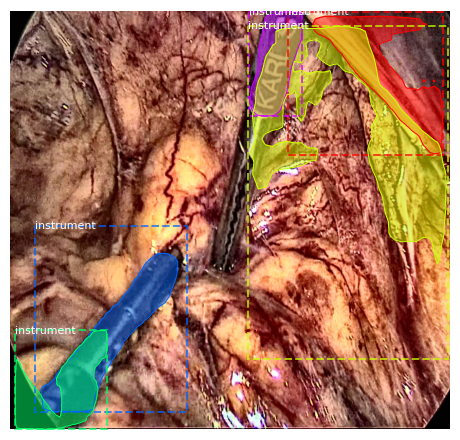

In [16]:
print("Choice details: \n"+
      "0 = Segmented image\n"+
      "1 = Enhanced and distance image\n"+
      "2 = De-Smoking\n"+
      "3 = De-Smoking and Distance\n"+
      "4 = De-Smoking and segmentation\n")
num_ip = int(input("enter choice to run the model(0/1/2/3/4): "))
main(num_ip)